In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [0]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  
  # if isinstance(value, type(tf.constant(0))):
  #   value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def tf_example_protobuf(image, label):
    feature_dict = {
        'image': _bytes_feature(image.tostring()),
        'label': _int64_feature(label),
    }

    features = tf.train.Features(feature=feature_dict)
    tf_example = tf.train.Example(features=features)
    protocol_message = tf_example.SerializeToString()

    return protocol_message

def convert_proto_message_to_np(protocol_message):
    feature_dict = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_out = tf.io.parse_single_example(serialized=protocol_message,
                                            features=feature_dict)
    
    image = tf.io.decode_raw(parsed_out['image'], out_type=tf.float32)
    # image = tf.reshape(image, shape=[32,32,3])
    label = parsed_out["label"]
    # label = tf.cast(parsed_out["label"], tf.int32)
    # label = tf.one_hot(label, 10, dtype=tf.int32)
    
    return (image,label)
    
def convert_np_to_tfrecords(images, labels,filename=None):

    # Converts a numpy array into TFReocrds
    
    if filename == None:
        filename = 'dataset.tfrecords'
    with tf.io.TFRecordWriter(filename) as writer:
        for img,label in zip(images,labels):
          # numpy check
          # if isinstance(x, (np.ndarray, np.generic)) and isinstance(y, (np.ndarray, np.generic)):
				  #   record = serialize_function(x, y)
          # else:
          #   record = serialize_function(x.numpy(), y.numpy())
            protocol_message = tf_example_protobuf(img,label)
            writer.write(protocol_message)
        


In [0]:
convert_np_to_tfrecords(x_train, y_train,filename='train.tfrecords')
convert_np_to_tfrecords(x_test, y_test, filename='test.tfrecords')


In [0]:
def input_foo(filenames, buffer_size = 8*1024, seed = 50, batch_size = 128):
  dataset = tf.data.TFRecordDataset(filenames=filenames, buffer_size=buffer_size)
  # dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=buffer_size,seed=seed))
  # dataset = dataset.apply(tf.data.experimental.map_and_batch(map_func=convert_proto_message_to_np,batch_size=batch_size,num_parallel_calls=tf.data.experimental.AUTOTUNE))
  dataset = dataset.map(convert_proto_message_to_np)
  if filenames == 'test.tfrecords':
    dataset = dataset.map(lambda x, y: (tf.reshape(x,[32,32,3]), y))
  else:
    dataset = dataset.map(lambda x, y: (tf.reshape(x,[40,40,3]), y))
  dataset = dataset.apply(tf.data.experimental.prefetch_to_device('/GPU:0'))
  dataset = dataset.prefetch(4)
  return dataset

In [0]:
test_dataset = input_foo(filenames='test.tfrecords')
train_dataset = input_foo(filenames='train.tfrecords')

In [0]:
def replace_slice(input_: tf.Tensor, replacement, begin) -> tf.Tensor:
    inp_shape = tf.shape(input_)
    size = tf.shape(replacement)
    padding = tf.stack([begin, inp_shape - (begin + size)], axis=1)
    replacement_pad = tf.pad(replacement, padding)
    mask = tf.pad(tf.ones_like(replacement, dtype=tf.bool), padding)
    return tf.where(mask, replacement_pad, input_)


def get_cutout_eraser(minimum, maximum, area: int = 81, c: int = 3, min_aspect_ratio=0.5, max_aspect_ratio=1 / 0.5):
    sqrt_area = np.sqrt(area)

    def get_h_w(aspect_ratio):
        h = sqrt_area / aspect_ratio
        w = tf.math.round(area / h)
        h = tf.math.round(h)
        h = tf.cast(h, tf.int32)
        w = tf.cast(w, tf.int32)
        return h, w

    def tf_cutout(x: tf.Tensor) -> tf.Tensor:
        """
        Cutout data augmentation. Randomly cuts a h by w whole in the image, and fill the whole with zeros.
        :param x: Input image.
        :param h: Height of the hole.
        :param w: Width of the hole
        :param c: Number of color channels in the image. Default: 3 (RGB).
        :return: Transformed image.
        """
        p_1 = np.random.rand()
        if p_1 > 0.5:
          return x
        
        dtype = x.dtype
        minval = tf.cast(minimum, dtype=dtype)
        maxval = tf.cast(maximum, dtype=dtype)

        aspect_ratio = tf.random.uniform([], min_aspect_ratio, max_aspect_ratio)
        h, w = get_h_w(aspect_ratio)

        shape = tf.shape(x)
        x0 = tf.random.uniform([], 0, shape[0] + 1 - h, dtype=tf.int32)
        y0 = tf.random.uniform([], 0, shape[1] + 1 - w, dtype=tf.int32)

        # slic = tf.random.uniform([h, w, c], minval=minval, maxval=maxval, dtype=dtype)
        img_mean = tf.reduce_mean(x)
        
        # find cut portion mean instead of whole mean

        slic = tf.fill([h, w, c], img_mean)
        # print(tf.shape(slic))
        # plt.imshow(slic)
        # plt.show()
        
        x = replace_slice(x, slic, [x0, y0, 0])
        return x

    return tf_cutout
    
cutout = get_cutout_eraser(0,255)


In [0]:
lr = []
ep = []
trainAcc = []
testAcc = []
mt = []

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1


schedule = np.interp(np.arange(EPOCHS+1), [0, int((EPOCHS+1)*0.2), int((EPOCHS+1)*0.76), EPOCHS], [LEARNING_RATE*0.15, LEARNING_RATE, LEARNING_RATE*0.05, 0.001]) 
lr_schedule = lambda t: schedule[t]
# lr_schedule = lambda t: np.interp([t], [0, 5, 6, 12, 16, 19, 22, 24], [0.03, 0.6, 0.58, 0.387, 0.2, 0.1, 0.01, 0.001])[0]
# lr_schedule = lambda t: np.interp([t], [0,     5,    6,     12,     16,  19, 22, 24], 
#                                          [0.03,  0.6, 0.58,  0.387,  0.2,  0.1,0.01,0.001])[0]

m_schedule = np.interp(np.arange(EPOCHS+1), [0, int((EPOCHS+1)*0.2), int((EPOCHS+1)*0.76), EPOCHS], [MOMENTUM*1.01, MOMENTUM*0.91, MOMENTUM, MOMENTUM]) 
moment_schedule = lambda mt: m_schedule[mt]



# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()

lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
moment_func = lambda: moment_schedule(global_step/batches_per_epoch)/BATCH_SIZE

opt = tf.train.MomentumOptimizer(lr_func, momentum=moment_func, use_nesterov=True)
# opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

data_aug = lambda x, y: (cutout(tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3]))), y)

In [0]:
t = time.time()
test_set = test_dataset.batch(BATCH_SIZE)

for epoch in range(EPOCHS):

  lr_ep = lr_schedule(epoch+1)
  lr.append(lr_ep)
  mt_ep = moment_schedule(epoch+1)
  mt.append(mt_ep)

  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = train_dataset.map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
  
  testAcc.append(test_acc / len_test)
  trainAcc.append(train_acc / len_train)
  ep.append(epoch+1)  
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



epoch: 1 lr: 0.128 train loss: 1.7754685852050782 train acc: 0.37986 val loss: 1.5188416076660156 val acc: 0.4443 time: 60.88217806816101



epoch: 2 lr: 0.196 train loss: 1.4042442224121094 train acc: 0.48944 val loss: 1.139910662841797 val acc: 0.5861 time: 104.51003980636597



epoch: 3 lr: 0.264 train loss: 1.113861138305664 train acc: 0.59786 val loss: 0.9067821990966797 val acc: 0.6811 time: 143.92705464363098



epoch: 4 lr: 0.332 train loss: 0.9230862451171875 train acc: 0.67226 val loss: 0.7898853042602539 val acc: 0.7147 time: 183.85640931129456



epoch: 5 lr: 0.4 train loss: 0.7967611990356446 train acc: 0.72146 val loss: 0.8267319305419922 val acc: 0.712 time: 223.58475995063782



epoch: 6 lr: 0.3728571428571429 train loss: 0.8932051397705079 train acc: 0.6928 val loss: 0.7091077285766602 val acc: 0.7571 time: 267.75412917137146



epoch: 7 lr: 0.34571428571428575 train loss: 0.6538481140136718 train acc: 0.77182 val loss: 0.7138791885375977 val acc: 0.756 time: 311.8507812023163



epoch: 8 lr: 0.3185714285714286 train loss: 0.45920400695800784 train acc: 0.84406 val loss: 0.48350919647216795 val acc: 0.8339 time: 351.5057101249695



epoch: 9 lr: 0.2914285714285715 train loss: 0.4986479650878906 train acc: 0.8272 val loss: 0.5502620864868164 val acc: 0.818 time: 395.3718135356903



epoch: 10 lr: 0.26428571428571435 train loss: 0.45326685333251954 train acc: 0.84268 val loss: 0.4715749526977539 val acc: 0.8376 time: 439.4320147037506



epoch: 11 lr: 0.23714285714285716 train loss: 0.32939663375854494 train acc: 0.88794 val loss: 0.3878004524230957 val acc: 0.8639 time: 478.5370936393738



epoch: 12 lr: 0.21000000000000002 train loss: 0.386162756652832 train acc: 0.8656 val loss: 0.42999188079833983 val acc: 0.8521 time: 521.7876896858215



epoch: 13 lr: 0.18285714285714288 train loss: 0.2671123277282715 train acc: 0.91056 val loss: 0.48612456970214846 val acc: 0.8403 time: 560.8996448516846



epoch: 14 lr: 0.15571428571428575 train loss: 0.24321491165161133 train acc: 0.91788 val loss: 0.3224674087524414 val acc: 0.89 time: 600.3395869731903



epoch: 15 lr: 0.12857142857142861 train loss: 0.2160884033203125 train acc: 0.92904 val loss: 0.36889892349243164 val acc: 0.8763 time: 639.3395481109619



epoch: 16 lr: 0.10142857142857148 train loss: 0.28826113494873046 train acc: 0.901 val loss: 0.32345254211425783 val acc: 0.89 time: 682.8805432319641



epoch: 17 lr: 0.07428571428571429 train loss: 0.18266862808227538 train acc: 0.94104 val loss: 0.2950071105957031 val acc: 0.9005 time: 722.3092703819275



epoch: 18 lr: 0.04714285714285715 train loss: 0.16532075881958008 train acc: 0.94672 val loss: 0.2813082374572754 val acc: 0.9039 time: 761.9203741550446



epoch: 19 lr: 0.020000000000000004 train loss: 0.237039560546875 train acc: 0.91936 val loss: 0.288917472076416 val acc: 0.9025 time: 805.1840553283691



epoch: 20 lr: 0.016200000000000003 train loss: 0.22331365768432618 train acc: 0.92464 val loss: 0.2598148994445801 val acc: 0.9139 time: 848.6258234977722



epoch: 21 lr: 0.012400000000000003 train loss: 0.14027669929504394 train acc: 0.95676 val loss: 0.25935340881347657 val acc: 0.9123 time: 888.3617742061615



epoch: 22 lr: 0.008600000000000003 train loss: 0.13480024108886718 train acc: 0.95914 val loss: 0.2521799331665039 val acc: 0.9148 time: 928.1363341808319



epoch: 23 lr: 0.004800000000000002 train loss: 0.21089532188415527 train acc: 0.92914 val loss: 0.2587631881713867 val acc: 0.9132 time: 972.0553333759308



epoch: 24 lr: 0.001 train loss: 0.20860285469055176 train acc: 0.92958 val loss: 0.2553267234802246 val acc: 0.9137 time: 1015.0632221698761


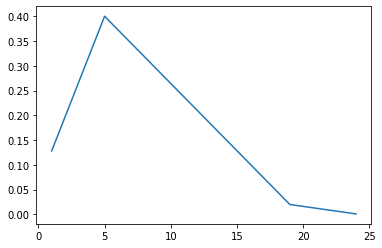

In [0]:
plt.plot(ep, lr)

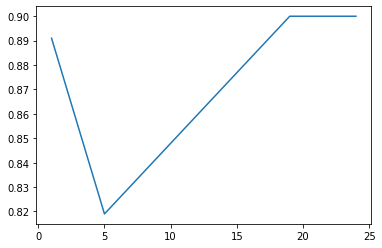

In [0]:
plt.plot(ep, mt)

In [0]:
# def random_erasing(img, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3):
#     '''
#     img is a 3-D variable (ex: tf.Variable(image, validate_shape=False) ) and  HWC order
#     '''
#     # HWC order
#     height = tf.shape(img)[0]
#     width = tf.shape(img)[1]
#     channel = tf.shape(img)[2]
#     area = tf.cast(width*height, tf.float32)

#     erase_area_low_bound = tf.cast(tf.round(tf.sqrt(sl * area * r1)), tf.int32)
#     erase_area_up_bound = tf.cast(tf.round(tf.sqrt((sh * area) / r1)), tf.int32)
#     h_upper_bound = tf.minimum(erase_area_up_bound, height)
#     w_upper_bound = tf.minimum(erase_area_up_bound, width)

#     h = tf.random.uniform([], erase_area_low_bound, h_upper_bound, tf.int32)
#     w = tf.random.uniform([], erase_area_low_bound, w_upper_bound, tf.int32)

#     x1 = tf.random.uniform([], 0, height+1 - h, tf.int32)
#     y1 = tf.random.uniform([], 0, width+1 - w, tf.int32)

#     erase_area = tf.cast(tf.random.uniform([h, w, channel], 0, 255, tf.int32), tf.uint8)

#     erasing_img = img[x1:x1+h, y1:y1+w, :].assign(erase_area)

#     return tf.cond(tf.random.uniform([], 0, 1) > probability, lambda: img, lambda: erasing_img)

In [0]:
# for (x, y) in train_set:
#   plt.imshow(x)
#   plt.show()
#   x = cutout(x)
#   plt.imshow(x)
#   plt.show()
#   break;

In [0]:
# class stop_at_Acc(tf.keras.callbacks.Callback):
#     def __init__(self,validation_iterator, validation_steps, threshold = 0.85, ):
#         super(stop_at_Acc, self).__init__()
#         self.threshold = threshold
#         self.validation_iterator = validation_iterator
#         self.validation_steps = validation_steps

#     def on_epoch_end(self, epoch, logs={}):
#         # score = self.model.evaluate_generator(self.validation_iterator,steps=len(self.validation_iterator)) #use for genrator
#         score = model.evaluate(self.validation_iterator,steps=self.validation_steps, verbose=0)
#         acc = score[1]
#         if acc >= self.threshold:
#             self.model.stop_training = True
#             print("Stopping Training:: Val Acc : %.3f Achieved"%(acc))
            
# stopper = stop_at_Acc(test_dataset, validation_steps=len_test//batch_size, threshold = 0.85)